      index evaluation     score    type
0         0   16768000  1.810245  normal
1         1   33536000  2.960265  normal
2         2   50304000  3.696758  normal
3         3   67072000  3.696758  normal
4         4   83840000  3.788749  normal
...     ...        ...       ...     ...
3644     24  264096000  6.440283      GA
3645     25  278768000  6.440283      GA
3646     26  293964000  6.440283      GA
3647     27  309684000  8.581218      GA
3648     28  314400000  8.581218      GA

[3649 rows x 4 columns]


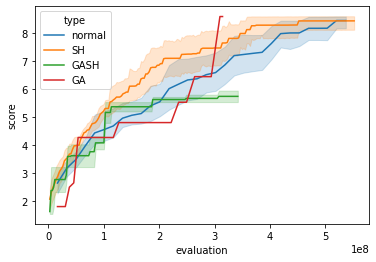

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
from math import floor
import itertools

root_dir = os.path.dirname(Path().resolve())
root_dir=os.path.join(root_dir, 'examples')
seed=10
expr_name='Jumper-v0_PlatformJumper-v0'
expr_name_normal='UpStepper-v0_TournamentGA'
expr_name_fast='UpStepper-v0_TournamentFastGA'
expr_name_suha='UpStepper-v0_TournamentSuHaGA'
expr_name_gash='UpStepper-v0_SuHaGA'
expr_name_ga='UpStepper-v0_GA'



generation=31


def max_fit_list(save_dir,generation,is_multi=False):
    fitness_gen=[]
    evaluation_list=[]
    for i in range(generation+1):
        log_dir = os.path.join(save_dir,'generation_'+str(i),'output.txt')
        with open(log_dir) as f:
            fitnesses=[]
            for line in f:
                try:
                    if is_multi:
                        fitnesses.append(float(line.split()[2]))
                    else:
                        fitnesses.append(float(line.split()[1]))
                except:
                    evaluation_list.append(int(line.split()[2]))
            if is_multi:
                evaluation_list.append(fitnesses[len(fitnesses)-1])
                del fitnesses[len(fitnesses)-1]
            fitness_gen.append(max(fitnesses))
    return fitness_gen,evaluation_list

def average_graph(expr_name,seed_list,generation,is_multi):
    mat=np.empty([0,generation+1])
    for seed in seed_list:
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        np_arr=np.array(fitness_list)[np.newaxis,:]
        mat=np.concatenate([mat,np_arr])
    data=np.average(mat,axis=0)
    return data,evaluation_list

def data_for_confidence(expr_name,seed_list,generation,is_multi,expr_type,calc_step_func):
    df=pd.DataFrame(columns=['evaluation','score'])
    for seed in seed_list:
        sub_df = pd.DataFrame(columns=['evaluation','score'])
        log_dir=expr_name+'_seed:'+str(seed)
        save_dir = os.path.join(root_dir, 'saved_data',log_dir)
        fitness_list,evaluation_list=max_fit_list(save_dir,generation,is_multi=is_multi)
        step_list=calc_step_func(save_dir,generation)
        sub_df['evaluation'] =  step_list
        sub_df['score'] = fitness_list
        df = pd.concat([df,sub_df],axis=0)
    df['type']=np.array([expr_type for i in range(len(df))])
    return df

def load_steps(save_dir,generation):
    steps_list=[]
    for i in range(generation+1):
        path=os.path.join(save_dir,'generation_'+str(i),'steps.txt')
        gen_steps=[]
        with open(path,'r') as f:
            for line in f:
                gen_steps.append(int(line.split('\t\t')[1]))
        steps_list.append(sum(gen_steps))
    accm_list=list(itertools.accumulate(steps_list))
    return np.array(accm_list)

def SH_steps(save_dir,generation):
    steps_list=[]
    for i in range(generation+1):
        this_gen_step=26200*16+52400*8+131000*4+262000*2+524000*2
        steps_list.append(this_gen_step)
    accm_list=list(itertools.accumulate(steps_list))
    return np.array(accm_list)

def normal_steps(save_dir,generation):
    steps_list=[]
    for i in range(generation+1):
        this_gen_step=524000*32
        steps_list.append(this_gen_step)
    accm_list=list(itertools.accumulate(steps_list))
    return np.array(accm_list)

                
    
# def data_for_confidence_multi(...):
# data_for_confidence()
# list
# data['hue'] = list

def plot_confidence(df):
    
    df=df.reset_index()
    print(df)
    sns.lineplot(x="evaluation", y="score", data=df,hue='type')
    plt.xlabel('evaluation')
    plt.savefig('evaluation_score.pdf')

def plot_graph(data,eval_list,label,is_eval_base=True):
    fig = plt.figure(figsize=(12, 8)) #...1
    
    # Figure内にAxesを追加()
    ax = fig.add_subplot(111) #...2
    if is_eval_base==False:
        eval_list[1]=np.array(eval_list[1])/2
    ax.plot(eval_list[1], data[1], label=label[1]) #...3
    ax.plot(eval_list[0], data[0], label=label[0]) #...3
    plt.xlabel('evaluations' if is_eval_base else 'evaluated design')
    plt.ylabel('score of platformjumper')
    plt.ylim([1.7,2.8])

    # 凡例の表示
    plt.legend()

    # プロット表示(設定の反映)
    plt.show()
    

#data_normal,eval_list_normal=average_graph(expr_name_normal,[0,100,6,9],31,False)
#data_fast,eval_list_fast=average_graph(expr_name_fast,[6,7,8,9,10,11,12,13,14,15],31,False)
df_normal=data_for_confidence(expr_name_normal,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],31,False,'normal',normal_steps)
#df_fast=data_for_confidence(expr_name_fast,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],31,False,11/16.0,'fast')
df_suha=data_for_confidence(expr_name_suha,range(15),187,False,'SH',SH_steps)
df_gash=data_for_confidence(expr_name_gash,[2,3],143,False,'GASH',load_steps)
df_ga=data_for_confidence(expr_name_ga,[0],28,False,"GA",load_steps)
#df_ga=data_for_confidence()
#df_normal.head(5)
plot_confidence(pd.concat([df_normal,df_suha,df_gash,df_ga]))
#plot_graph([data_single,data_multi],[eval_list_single,eval_list_multi],['GA:4 seed average','multi:5 seed average'])

      index evaluation     score    type
0         0         32  1.734620  normal
1         1         64  1.734620  normal
2         2         96  1.734984  normal
3         3        128  1.752009  normal
4         4        160  1.752009  normal
...     ...        ...       ...     ...
1541    176        991  3.650348      SH
1542    177        996  3.650348      SH
1543    178       1002  3.650348      SH
1544    179       1007  3.650348      SH
1545    180       1013  3.650348      SH

[1546 rows x 4 columns]


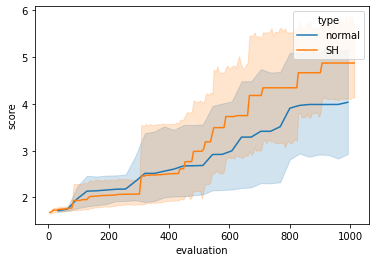

In [3]:
expr_name_normal='PlatformJumper-v0_TournamentGA'
expr_name_suha='PlatformJumper-v0_TournamentSuHaGA'
df_normal=data_for_confidence(expr_name_normal,[0,1,2,3,4,5,6,10,20],30,False,1,'normal')
df_suha=data_for_confidence(expr_name_suha,[0,1,3,5,6,9,10],180,False,7/40.0,'SH')
plot_confidence(pd.concat([df_normal,df_suha]))